# UHECR anisotropy model

Based on the following paper:   
*Soiaporn, K. et al., 2012. Multilevel Bayesian framework for modeling the production, propagation and detection of ultra-high energy cosmic rays. arXiv.org, astro-ph.HE(3), pp.1249–1285.*
  
      
### Data  
https://www.auger.org/index.php/document-centre/viewdownload/115-data/2354-list-of-ultra-high-energy-cosmic-ray-events-2014

### Candidate source catalog
Véron-Cetty and Véron catalog. In particular a sub-sample of 17 infra-red bright AGN within 15 Mpc. Small nearby sample motivated by use of MCMC (want to keep things computationally cheap) and lack of consideration for UHECR energies (would be an extension).


Isotropic background component also considered.

### Extensions
First order: Use of HMC to allow for a larger catalog and inclusion of the UHECR energies.

### Analysis package

FANCY: https://github.com/cescalara/fancy

In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from fancy import *

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


(<Figure size 864x432 with 2 Axes>,
 <fancy.allskymap.allskymap.AllSkyMap at 0x114c8ab38>)

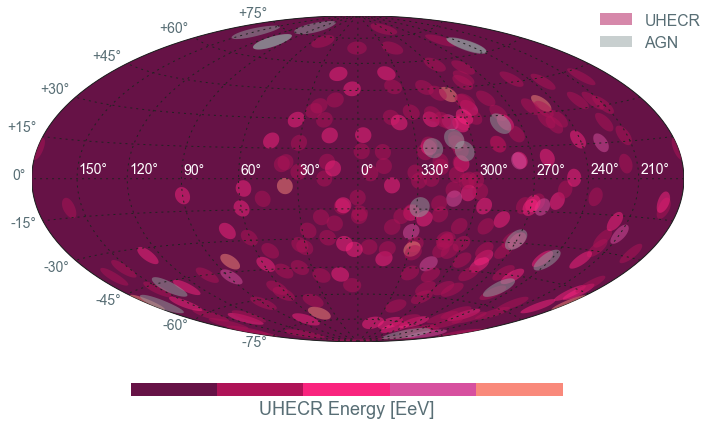

In [3]:
# read in the data
uhecr_file = '../data/auger_UHECR_list.dat'
agn_file = '../data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add some data
data.add_source(agn_file, 'AGN')
data.add_uhecr(uhecr_file, 'UHECR')

# plot a summary of the data
data.show()

## Likelihood of the true arrival direction

The UHECR data supplied are the result of estimates of the true direction summarised by a best fit direction (coordinates on the celestial sphere) and a typical directional uncertainty.


These summaries can be used to approximate the likelihood function using a Fisher distribution:

<div><center>
$ l(\omega_i) := p(d_i | \omega_i) = \frac{\kappa_c}{4 \pi sinh(\kappa_c)}e^{\kappa_cn_i.\omega_i}$
<center></div>
    
Where:

* $n_i$ us the best-fit arrival direction 
* $\omega_i$ is the true arrival direction 
* $d_i$ is the data associated with UHECR $i$
* $\kappa_c$ is the concentration parameter of the distribution (ie. how large an uncertainty)

## PAO exposure

PAO is not equally sensitive to all arrival directions $\omega_i$. The exposure of the instrument also changes in time. The expected number of UHECR from a certain arrival direction $\omega$ in a smalle time interval $dt$ is $FA_{\perp}(t,\omega)dt$ where F is the flux of UHECR from direction $\omega$ and $A_{\perp}(t, \omega)$ is the projected area of the observatory towards $\omega$ at time $t$.

The total expected number of UHECR can be written $F\epsilon(\omega)$ where $\epsilon(\omega)$ is the exposure map:

<div><center>
$ \epsilon(\omega) = \int_T A_{\perp}(t, \omega) dt $    
<center></div>

Where T represents all operational time intervals of the observatory.

The projected area factor can be written $A_{\perp} = A(t) \mu(t, \omega) $, where A(t) is the effective planar area of the detection volume (increases with time as the detector is upgraded) and $\mu(t, \omega)$ is a projection factor (varies over one sidereal day). This can therefore be approximated as:

<div><center>
$ \epsilon(\omega) = \int A_{\perp}m(\omega) dt $    
<center></div>

Where $m(\omega)$ is the projection factor average over one sidereal day. Following *Sommers, P., 2000. Cosmic Ray Anisotropy Analysis with a Full-Sky Observatory. arXiv.org, astro-ph(4), pp.271–286,* the averaged projection factor can be written:

<div><center>
$ m(\omega) = m(\delta) \propto cos(a_0)cos(\delta)sin(\alpha_m) + \alpha_m sin(a_0)sin(\delta) $
<center></div>
    
 Where: 
 
 * $a_0$ is the latitude of the observatory (-35.5$^\circ$ for PAO)
 * $ \alpha_m = \left\{
                \begin{array}{ll}
                  0 & \text{if $\xi \gt 1$} \\
                  \pi & \text{if $\xi \lt -1 $} \\
                  cos^{-1}(\xi) & \text{otherwise}
                \end{array}
              \right. $
              
* $\xi = \frac{cos(\theta_m) - sin(a_0)sin(\delta)}{cos(a_0)cos(\delta)}$
* $\theta_m$ is the threshold for the maximum detectable zenith angle


The relative exposure map can be found by converting $m(\delta)$ to $m(\omega) = m(\text{lon, lat})$

limiting declination 44.549098196392805 degrees


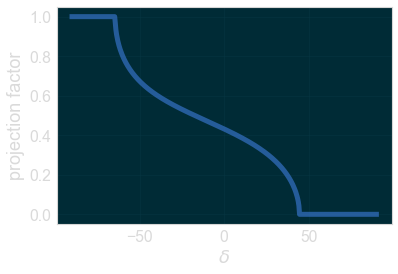

In [4]:
# add the Pierre Auger Observatory as a detector
auger_coords = [-35.5, -69.3] # lat, lon in degrees
threshold_zenith_angle = 80 # degrees
data.add_detector(auger_coords, threshold_zenith_angle, label = 'Auger')

# plot the exposure as a function of declination
data.detector['Auger'].show(view = 'decplot', cmap = 'sunset')

# display the limiting declination
print('limiting declination', data.detector['Auger'].limiting_dec.deg, 'degrees')

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


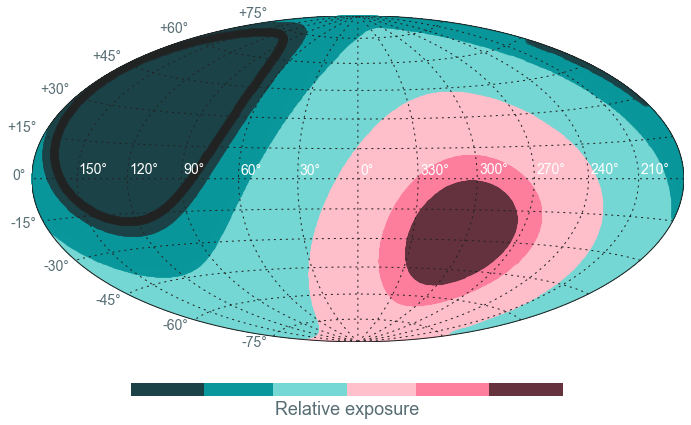

In [5]:
# plot the exposure (this can take ~15 s to run...)
data.detector['Auger'].show(view = 'map', cmap = 'macplus')

## Modeling the sources

Let $F_k$ be the flux of UHECR from source $k$ entering a detector with complete sky exposure and unit cross-sectional area. The possible directions are described by the proposed source catalog (17 AGN in this case).The number of sources is $N_A = 17$.

In order to account from UHECR coming from *uncatalogued* sources, consider an isotropically distributed background component at $k=0$ that is described fully by a single parameter $F_0$. A model must specify the *luminosity function* or distribution for $\{F_k\} = \{F_0, \mathbf{F}\} $.  

For the purposes of this exercise, we assume a standard candle luminosity function:

<div><center>
$F_k = I/D_k^2$
<center></div>
    
Where $D_k$ is the known distance to the potential sources. Energy attentuation is also neglected here (not ridiculous for sources within 15 Mpc) for simplicity.

We summarise with the total source flux $F_A = \sum_{k>0} F_k$. Thus $F_k = w_kF_A$, with the weights $w_k$:

<div><center>
$w_k = \frac{1/D_k^2}{\sum_{j=1}^{N_A} 1/D_j^2}$
<center></div>
    
for $k = 1$ to $N_A$. 

### Prior specification

We must specify priors for $F_0$ and $F_A$, or similarly $F_T = F_0 + F_A$. Total UHECR flux is measured by Auger in addition to the arrival directions. For the problem considered, it makes more sense to reparametrise $(F_0, F_A) \rightarrow (F_T, f)$ where $f = F_A/(F_0 + F_A)$ is the fraction of the total flux attributed to the source population. This allows to specifiy a single flux prior common to all models (robust).

Choose independent priors for the total flux and the associated fraction: $g(F_T)$ and $h(f)$. The joint prior density for $(F_0, F_A)$ is then:

<div><center>
$\pi(F_0, F_A) = \frac{g(F_0 + F_A)h(F_A/(F_0 + F_A))}{F_0 + F_A}$
<center></div>
    
Where the denominator appears due to the Jacoboan of the transformation. For the calculations below, we adopt an exponential prior with scale s for $F_T$ and a beta prior for $f$ with shape parameters $(a,b)$:

<div><center>
$g(F_T) = \frac{1}{s}e^{-F_T/s}$ and $h(f) = \frac{1}{B(a,b)}f^{a-1}(1-f)^{b-1}$
<center></div>
    
Where $B(a,b)$ is the beta function. These hyperparameters are set as follows:

* $s = 0.01 \times 4 \pi km^{-1}yr^{-1}$ (AGASA/HiRes)
* $a = b= 1$ corresponding to a uniform prior on [0,1]

### Mark distributions
Cosmic ray arrival times are modelled as a superposition of homogeneous poisson point processes. Each UHECR has a label, $\lambda$, specifying its source ($\lambda = 0$ for background and $\lambda = k$ for the AGN sources). A superposition of poisson processes is also a poisson process so we can consider the arrival times of UHECRs at Earth to come from a total event rate point process, and the labels to come from a categorialn mark distribution with pmf:

<div><center>
$P(\lambda = k | F_0, \mathbf{F}) = \frac{F_k}{\sum_{j=0}^{N_A} F_j}$
<center></div>
    
Energies can also be assigned as marks, drawing from the emission spectra connected to the physical acceleration processes, but this extension is not considered in the simplest form of this example as all sources are within 15 Mpc and so energy losses are negligible. Also PAO only provides data above a certain threshold. 

## Propagation

A simple phenomenological model is used in Soiaporn et al. (2012) due to the large uncertainties associated with the physical modelling of this process. 

A Fisher distribution is used for deflection angles:

<div><center>
$ \rho_k(\omega | \kappa) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa\omega . \varpi_k} $
<center></div>
    
Where:

* $\omega$ is the arrival direction
* $\kappa$ is the concentration parameter of the Fisher distribution
* $\varpi_k$ is the direction of source $k$

For the isotropic background population, we have:

<div><center>
$ \rho_0(\omega | \kappa)  = \frac{1}{4 \pi}$
<center></div>

This $\kappa$ parameter is covenient for computation, but not interpretation. The contour of the Fisher density bounding a region ocntining probability $P$ is azimuthaly symmetric with angular radius $\theta_P$ satisfying:

<div><center>
$ \int_{\Omega} d\omega \rho_k(\omega | \kappa) = \frac{1 - e^{\kappa[1 - cos(\theta_p)]}}{1 - e^{-2\kappa}} = P $    
<center></div>

Where $\Omega$ is the cone of solid angle subtended by the contour. $P = 0.683$ is analogous to the $1 \sigma$ region of a normal distribution. 

The prior for $\kappa$ is a log-flat prior density for $\kappa \in [1, 1000]$:

<div><center>
$ p(\kappa) = \frac{1}{log(1000)}\frac{1}{\kappa}$ for $1 \leq \kappa \leq 1000$
<center></div>

The upper limit => ~ 1 rad (iron nuclei), lower limit => 1 deg (protons with E = 100 EeV).

## Detection

In this model, the arrival rate of UHECRs into a unit volume is constant. However, the dection rate is not due to the limited exposure of PAO which changes in time as the Earth rotates (see above discussion on the exposure map). As a result, the poisson intensity function varies in time for detectable cosmic rays varies in time for each source.

Likelihood funciton for an inhomogeneous poisson with rate $r(t)$ has the form:

<div><center>
$ exp(-N_{exp}) \prod_i r(t_i) \delta t$
<center></div>
    
Where the events are detected at times $t_i$ within intervals $\delta t$ and $N_{exp}$ is the total expected number in the observing interval.

If the label and arrival direction are unknown. The uncertain direction can be introduced as a nuisance parameter using $l(\omega_i)$ with prior $\rho_k(\omega_i | \kappa) $(see above). This gives a factor $F_k f_{k, i} \delta t$ where $f_{k, i}$:

<div><center>
$ f_{k,i} \approx A_i cos(\theta_i) \int l_i(\omega_i) \rho_k (\omega_i | \kappa) d\omega_i$
<center></div>

Where $\theta_i$ is the zenith angle of UHECR $i$. This integral can be computed analytically. 

The total event rate combines the contributions from each source: $r(t_i) = \sum_k F_k f_{, i}(\kappa)$.

To calculate $N_{exp}$, we must account for the observatory's exposure map. The exposure factor for a source $K$ is:

<div><center>
$ \epsilon(\kappa) = \int d\omega \rho_k(\omega | \kappa)\epsilon(\omega) $
<center></div>
    
Therefore $N_{exp} = \sum_{k > 0} F_k \epsilon_k(\kappa)$. 

The prior probability mass function of a *detected* UHECR must be weighted according to the source exposures:

<div><center>
$ P(\lambda_i=k| F_0, \mathbf{F}, \kappa)  = \frac{F_k\epsilon_k(\kappa)}{\sum_{j=0}^{N_A}F_j \epsilon_j(\kappa)}$.
<center></div>
    

## The likelihood

<div><center>
$\mathcal{L}(F_0, \mathbf{F}, \kappa) = exp(-\sum_k F_k \epsilon_k) \prod_i(\sum_k f_{k,i} F_k)$
<center></div>

The product of sums factor resembles the likelihood for a finite mixture model, with the $f_{k,i}$ as the component densities and $F_k$ as the weights. We can rewrite the likelihood as a sum of products by introducing the latent label parameters:

<div><center>
$\mathcal{L}(F_0, \mathbf{F}, \kappa) = \sum_{\lambda}(\prod_k F_k^{m_k(\lambda)} e^{-F_k\epsilon_k})\prod_i f_{\lambda_i,i}$
<center></div>

Where $m_k$ is the multiplicity or number of UHECRs assigned to source k according to $\lambda$.

Now rewrite with $(F_0, \mathbf{F}) \rightarrow (f, F_T)$.

<div><center>
$ \mathcal{L}(f, F_T, \kappa) = \sum_k(1 - f)^{m_0(\lambda)} f^{N_C - m_0(\lambda)} F_T^{N_C} \times e^{-F_T[(1-f)\epsilon_0 + f\sum_{k \geq 1} w_k\epsilon_k]} \prod_{k \geq 1} w_k^{m_k(\lambda)} \prod_i f_{\lambda_i,i}$ 
<center></div>
    
for computations, it is useful to have the likelihood conditional on the label assignments. 

<div><center>
$P(D|\lambda,f,F_T, \kappa) = exp(-\sum_kF_k\epsilon_k)[\sum_k F_k \epsilon_k]^{N_C} \prod_i \frac{f_{\lambda_i, i}}{\epsilon_{\lambda_i}}$
<center></div>
    

## Computation

### Estimating $\kappa$

To estimate the deflection parameter, we need to marginalise over $F_T$ and $f$. Computing this is intractable as we must sum over all possible values of $\lambda$. Chib's method can be used to do this.

<div><center>
$ \mathcal{L}_m(\kappa) = \frac{P(D|F_T^*, f^*, \lambda^*) P(\lambda^*| F_T^*, f^*) P(F_T^*) P(f^*)}{P(F_T^*, f^*, \lambda^*|D)} || \kappa $
<center></div>
    
Where $F_T^*, f^*, \lambda^*$ are arbitrary values, but should in practice be close to regions of high posterior density. The numerator can be calculated analytically and the denominator using numerical integration and MCMC techniques (Gibb's sampling).


### Approach

To draw posterior samples, metropolis-within-Gibbs sampling of $f, F_T and \lambda$ was used in Soiaporn et al. (2012). For this work, we will try to implement a model based on the same principles into the **Stan** programing language to take advantage of their **Hamiltonian MC** framework, then compare the results. 

## Fitting the model with Stan

The model descibed above is written in soiaporn_model.stan. In order to pass the data to Stan, the variables are defined to have the same names as in this notebook and the data are organised into a python dictionary to be passed to rhe pyStan interface as shown below.  

In [6]:
# set up the data to be passed to the model
# to be continued!